In [1]:
import geopandas as gpd
import pandas as pd
import prostor.fetchers.projects as projects
import prostor.fetchers.scenarios as scenarios
import prostor.fetchers.territories as territories
from blocksnet.config import log_config

log_config.set_logger_level('WARNING')

/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
blocks = pd.read_pickle('./data/blocks.pickle')
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share,...,count_supermarket,capacity_swimming_pool,count_swimming_pool,capacity_train_station,count_train_station,capacity_university,count_university,capacity_veterinary,count_veterinary,site_area
0,"POLYGON ((388511.373 6644951.946, 388558.037 6...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.91818,LandUse.AGRICULTURE,0.918180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202399.732193
1,"POLYGON ((388558.037 6645102.374, 388511.373 6...",0.000000,0.938081,0.0,0.0,0.000000,0.0,0.00000,LandUse.BUSINESS,0.938081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201529.493481
2,"POLYGON ((387957.434 6643444.937, 388007.492 6...",0.000000,0.000000,0.0,0.0,0.891381,0.0,0.00000,LandUse.TRANSPORT,0.891381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164663.859830
3,"POLYGON ((388007.492 6643608.409, 387957.434 6...",0.934862,0.000000,0.0,0.0,0.000000,0.0,0.00000,LandUse.RESIDENTIAL,0.934862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161571.832511
4,"POLYGON ((388001.306 6643195.969, 388000.75 66...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.489152


In [3]:
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

In [4]:
from blocksnet.enums import LandUse

for lu in LandUse:
    blocks[lu.value] = blocks[lu.value].apply(lambda v : min(v,1))

In [5]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks, 10)

In [6]:
from blocksnet.machine_learning.regression import DensityRegressor

dr = DensityRegressor()
density_df = dr.evaluate(blocks, adjacency_graph)
density_df.head()

/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,fsi,gsi,mxi
0,0.062008,0.030930,0.625959
1,0.202340,0.090030,0.683971
2,0.151737,0.091165,0.075096
3,0.449142,0.139053,0.404539
4,0.079224,0.019164,0.141795


In [7]:
density_df.loc[density_df['fsi'] < 0, 'fsi'] = 0

density_df.loc[density_df['gsi'] < 0, 'gsi'] = 0
density_df.loc[density_df['gsi'] > 1, 'gsi'] = 1

density_df.loc[density_df['mxi'] < 0, 'mxi'] = 0
density_df.loc[density_df['mxi'] > 1, 'mxi'] = 1

density_df.loc[blocks['residential'] == 0, 'mxi'] = 0

density_df.head()

,fsi,gsi,mxi
0,0.062008,0.030930,0.000000
1,0.202340,0.090030,0.000000
2,0.151737,0.091165,0.000000
3,0.449142,0.139053,0.404539
4,0.079224,0.019164,0.000000


In [8]:
from blocksnet.analysis.indicators import calculate_development_indicators 

density_df['site_area'] = blocks['site_area']
development_df = calculate_development_indicators(density_df)
development_df.head()

,site_area,fsi,gsi,mxi,build_floor_area,footprint_area,living_area,non_living_area
0,202399.732193,0.062008,0.030930,0.000000,12550.416350,6260.321243,0.000000,12550.416350
1,201529.493481,0.202340,0.090030,0.000000,40777.554163,18143.767788,0.000000,40777.554163
2,164663.859830,0.151737,0.091165,0.000000,24985.657278,15011.641911,0.000000,24985.657278
3,161571.832511,0.449142,0.139053,0.404539,72568.711901,22467.055572,29356.894977,43211.816923
4,16.489152,0.079224,0.019164,0.000000,1.306344,0.316006,0.000000,1.306344


In [9]:
development_df['population'] = development_df['living_area'] // 20
development_df.head()

,site_area,fsi,gsi,mxi,build_floor_area,footprint_area,living_area,non_living_area,population
0,202399.732193,0.062008,0.030930,0.000000,12550.416350,6260.321243,0.000000,12550.416350,0.0
1,201529.493481,0.202340,0.090030,0.000000,40777.554163,18143.767788,0.000000,40777.554163,0.0
2,164663.859830,0.151737,0.091165,0.000000,24985.657278,15011.641911,0.000000,24985.657278,0.0
3,161571.832511,0.449142,0.139053,0.404539,72568.711901,22467.055572,29356.894977,43211.816923,1467.0
4,16.489152,0.079224,0.019164,0.000000,1.306344,0.316006,0.000000,1.306344,0.0


In [10]:
blocks.loc[:, development_df.columns] = development_df

In [11]:
from blocksnet.analysis.morphotypes import get_strelka_morphotypes


blocks_df = get_strelka_morphotypes(blocks)
blocks.loc[:, blocks_df.columns] = blocks_df
blocks.head()

2025-07-03 15:39:45.070 | WARNING  | blocksnet.analysis.morphotypes.schemas:_before_validate:17 - Column l not found in columns. Calculating from fsi and gsi


,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share,...,capacity_university,count_university,capacity_veterinary,count_veterinary,site_area,fsi,gsi,mxi,l,morphotype
0,"POLYGON ((388511.373 6644951.946, 388558.037 6...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.91818,LandUse.AGRICULTURE,0.918180,...,NaN,NaN,NaN,NaN,202399.732193,0.062008,0.030930,0.000000,2.004756,low-rise non-residential
1,"POLYGON ((388558.037 6645102.374, 388511.373 6...",0.000000,0.938081,0.0,0.0,0.000000,0.0,0.00000,LandUse.BUSINESS,0.938081,...,NaN,NaN,NaN,NaN,201529.493481,0.202340,0.090030,0.000000,2.247469,low-rise non-residential
2,"POLYGON ((387957.434 6643444.937, 388007.492 6...",0.000000,0.000000,0.0,0.0,0.891381,0.0,0.00000,LandUse.TRANSPORT,0.891381,...,NaN,NaN,NaN,NaN,164663.859830,0.151737,0.091165,0.000000,1.664419,low-rise non-residential
3,"POLYGON ((388007.492 6643608.409, 387957.434 6...",0.934862,0.000000,0.0,0.0,0.000000,0.0,0.00000,LandUse.RESIDENTIAL,0.934862,...,NaN,NaN,NaN,NaN,161571.832511,0.449142,0.139053,0.404539,3.230005,low-rise model
4,"POLYGON ((388001.306 6643195.969, 388000.75 66...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,None,NaN,...,NaN,NaN,NaN,NaN,16.489152,0.079224,0.019164,0.000000,4.133916,mid-rise non-residential


In [12]:
from blocksnet.analysis.accessibility import area_accessibility

area_acc_df = area_accessibility(acc_mx, blocks)
blocks= blocks.join(area_acc_df)


In [13]:
# Собираем все имена колонок, которые начинаются на 'capacity'
cols_to_drop = [col for col in blocks.columns if col.startswith('capacity')]
blocks = blocks.drop(columns=cols_to_drop)
cols_to_drop = [col for col in blocks.columns if col.startswith('count')]

# Удаляем их сразу все
blocks = blocks.drop(columns=cols_to_drop)
blocks['land_use'] = (
    blocks['land_use']
    .astype(str)
    .str.replace(r'^LandUse\.', '', regex=True)
)

In [14]:
list3 = [
    'residential', 'business', 'recreation', 'industrial',
    'transport', 'special', 'agriculture', 'land_use', 'share',
     'footprint_area','build_floor_area', 'living_area', 'non_living_area', 'population',
    'site_area', 'fsi', 'gsi', 'mxi', 'l', 'morphotype',
    'area_accessibility'
]


In [15]:
# Определяем имя колонки геометрии (обычно 'geometry')
geom_col = blocks.geometry.name 

# Оставляем только нужные колонки + геометрию
wanted_cols = list3 + [geom_col]
gdf_filtered = blocks[wanted_cols]
blocks = gdf_filtered

In [ ]:
blocks['id'] = blocks.index
blocks2 = blocks[['id', 'geometry']].copy()
blocks2.explore()

/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

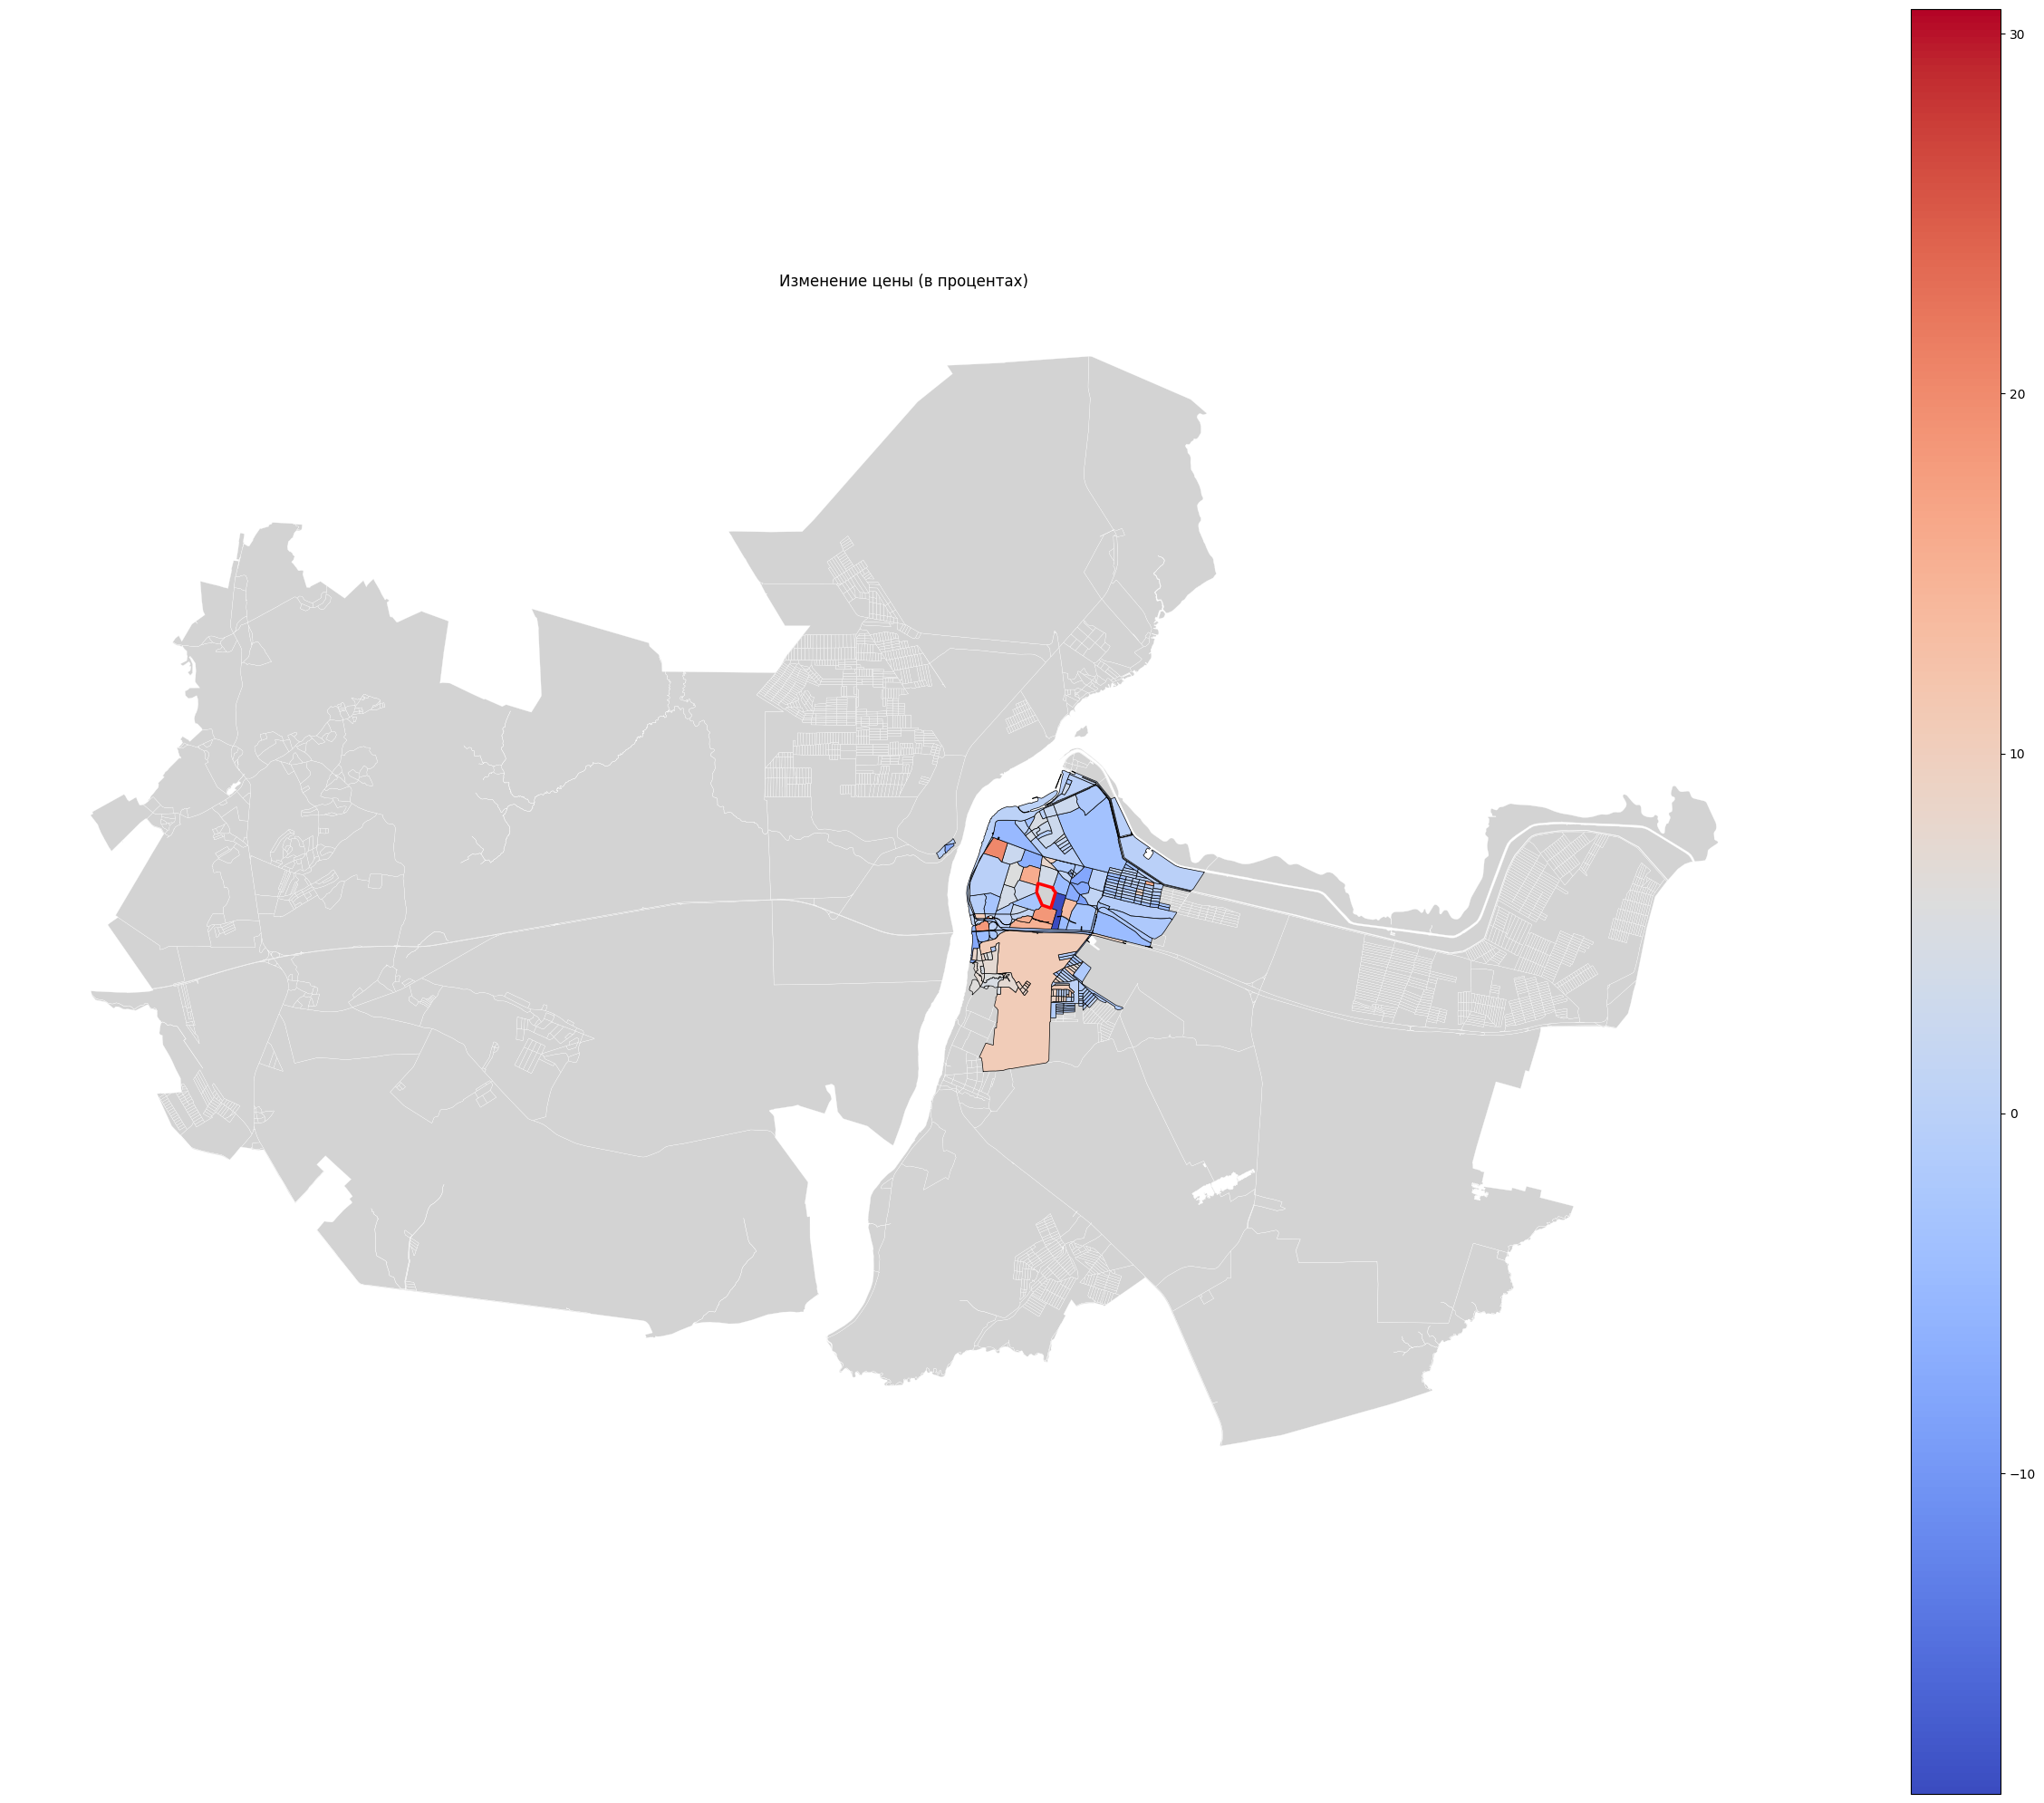

In [50]:
# ------------ 0. Библиотеки и константы ------------
import pandas as pd
import numpy as np
import geopandas as gpd
from catboost import CatBoostRegressor
from libpysal.weights import DistanceBand, lag_spatial
import matplotlib.pyplot as plt

# Список исходных фичей
orig_feats = [
    'residential','business','recreation','industrial','transport','special',
    'agriculture','land_use','share','footprint_area','build_floor_area',
    'living_area','non_living_area','population','site_area','fsi','gsi',
    'mxi','l','morphotype','area_accessibility'
]
# Категориальные фичи
cat_feats = ['land_use', 'morphotype']
numeric_feats = [c for c in orig_feats if c not in cat_feats]

# Радиусы для матриц соседства
radius_list = [300, 500, 1000, 2000, 3000]

# ------------ 1. Загрузка данных и модели ------------
# Предполагается, что у вас уже загружен GeoDataFrame blocks, например:
# blocks = gpd.read_file('blocks.geojson')

model = CatBoostRegressor()
model.load_model('/home/mvin/prostor-examples/examples/data/catboost_model.cbm')

# ------------ 2. Построение матриц соседства ------------
w_radii = {}
for r in radius_list:
    w = DistanceBand.from_dataframe(
        blocks, threshold=r, binary=True, silence_warnings=True
    )
    w.transform = 'r'
    w_radii[r] = w

# ------------ 3. Функция визуализации ------------
def plot_scenario_with_radii(
    blocks, w_radii, model,
    orig_feats, numeric_feats,
    target_idx, changes
):
    radius_list = sorted(w_radii.keys())

    # --- 0) Определяем соседей ---
    radius_ids = {}
    prev = set()
    for r in radius_list:
        ids = set(w_radii[r].neighbors.get(target_idx, [])) - prev
        radius_ids[r] = sorted(ids)
        prev |= ids

    # целевой и список всех соседей
    involved = [target_idx] + [i for r in radius_list for i in radius_ids[r]]
    # только соседи без target
    neighbor_idxs = [i for i in involved if i != target_idx]

    # --- 1) Лаг-признаки до изменений ---
    blocks_base = blocks.copy()
    lag_cols = []
    gm = blocks_base[numeric_feats].mean()
    for feat in numeric_feats:
        vec = blocks_base[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_base[col] = lag_spatial(w_radii[r], vec)
            lag_cols.append(col)
    for r in radius_list:
        ncol = f'n_neighbors_{r}'
        blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
        lag_cols.append(ncol)
    all_feats = orig_feats + lag_cols

    Xb = blocks_base.loc[involved, all_feats].copy()
    Xb['land_use']   = Xb['land_use'].fillna('missing').astype('category')
    Xb['morphotype'] = Xb['morphotype'].fillna('missing').astype('category')
    before = model.predict(Xb)

    # --- 2) Вносим изменения и пересчитываем лаги ---
    blocks_scn = blocks_base.copy()
    for feat, val in changes.items():
        blocks_scn.at[target_idx, feat] = val
    for feat in numeric_feats:
        vec = blocks_scn[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_scn[col] = lag_spatial(w_radii[r], vec)

    Xa = blocks_scn.loc[involved, all_feats].copy()
    Xa['land_use']   = Xa['land_use'].fillna('missing').astype('category')
    Xa['morphotype'] = Xa['morphotype'].fillna('missing').astype('category')
    after = model.predict(Xa)

    # 3) Рассчитываем pct_change только для involved
    pct = (np.exp(after - before) - 1) * 100
    gdf = blocks_scn.copy()
    gdf['pct_change'] = np.nan
    gdf.loc[involved, 'pct_change'] = pct

    # 4) Визуализация
    fig, ax = plt.subplots(figsize=(25, 20))

    # 4.1: серый фон для всех кварталов
    blocks.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.2, zorder=0)

    # 4.2: цветная заливка только для соседей
    # вычисляем scale только по соседям
    vmin = gdf.loc[neighbor_idxs, 'pct_change'].min()
    vmax = gdf.loc[neighbor_idxs, 'pct_change'].max()

    gdf.loc[neighbor_idxs].plot(
        ax=ax,
        column='pct_change',
        cmap='coolwarm',
        vmin=vmin, vmax=vmax,       # теперь без target_idx
        legend=True,                # убрать, если не нужна цветовая шкала
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )

    # 4.3: рамка целевого участка
    gdf.loc[[target_idx]].boundary.plot(
        ax=ax,
        edgecolor='red',
        linewidth=2.5,
        zorder=2
    )

    ax.axis('off')
    ax.set_title('Изменение цены (в процентах)', pad=12)
    plt.tight_layout()
    plt.show()


# ------------ 5. Пример использования ------------
target_idx = 15
changes = {
    'land_use': 'RESIDENTIAL',
    'share': 0.95,
    'footprint_area': 49039.24,
    'build_floor_area': 230279.19,
    'living_area': 155896.85,
    'population': 5168,
    'fsi': 2.80,
    'mxi': 0.68,
    'l': 6.93,
    'share_living': 4.69
}

plot_scenario_with_radii(
    blocks=blocks,
    w_radii=w_radii,
    model=model,
    orig_feats=orig_feats,
    numeric_feats=numeric_feats,
    target_idx=target_idx,
    changes=changes
)



/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

Δ цены в процентах (после − до):
 • 15 (target): 18.052 → 19.160 (Δ +1.109 log, +203.0%)
 • 10 (radius_500m): 18.047 → 18.217 (Δ +0.170 log, +18.5%)
 • 11 (radius_500m): 19.040 → 18.831 (Δ -0.210 log, -18.9%)
 • 17 (radius_500m): 18.109 → 18.063 (Δ -0.046 log, -4.5%)
 • 32 (radius_500m): 18.677 → 18.714 (Δ +0.037 log, +3.8%)
 • 35 (radius_500m): 19.922 → 19.895 (Δ -0.027 log, -2.7%)
 • 9 (radius_1000m): 19.659 → 19.699 (Δ +0.040 log, +4.0%)
 • 12 (radius_1000m): 18.444 → 18.585 (Δ +0.141 log, +15.2%)
 • 13 (radius_1000m): 17.601 → 17.555 (Δ -0.046 log, -4.5%)
 • 14 (radius_1000m): 17.510 → 17.635 (Δ +0.125 log, +13.3%)
 • 16 (radius_1000m): 18.022 → 17.949 (Δ -0.073 log, -7.0%)
 • 18 (radius_1000m): 17.972 → 17.895 (Δ -0.077 log, -7.4%)
 • 19 (radius_1000m): 17.360 → 17.373 (Δ +0.013 log, +1.3%)
 • 21 (radius_1000m): 14.982 → 15.014 (Δ +0.032 log, +3.3%)
 • 22 (radius_1000m): 15.050 → 15.010 (Δ -0.041 log, -4.0%)
 • 23 (radius_1000m): 15.004 → 14.964 (Δ -0.040 log, -4.0%)
 • 24 (radius

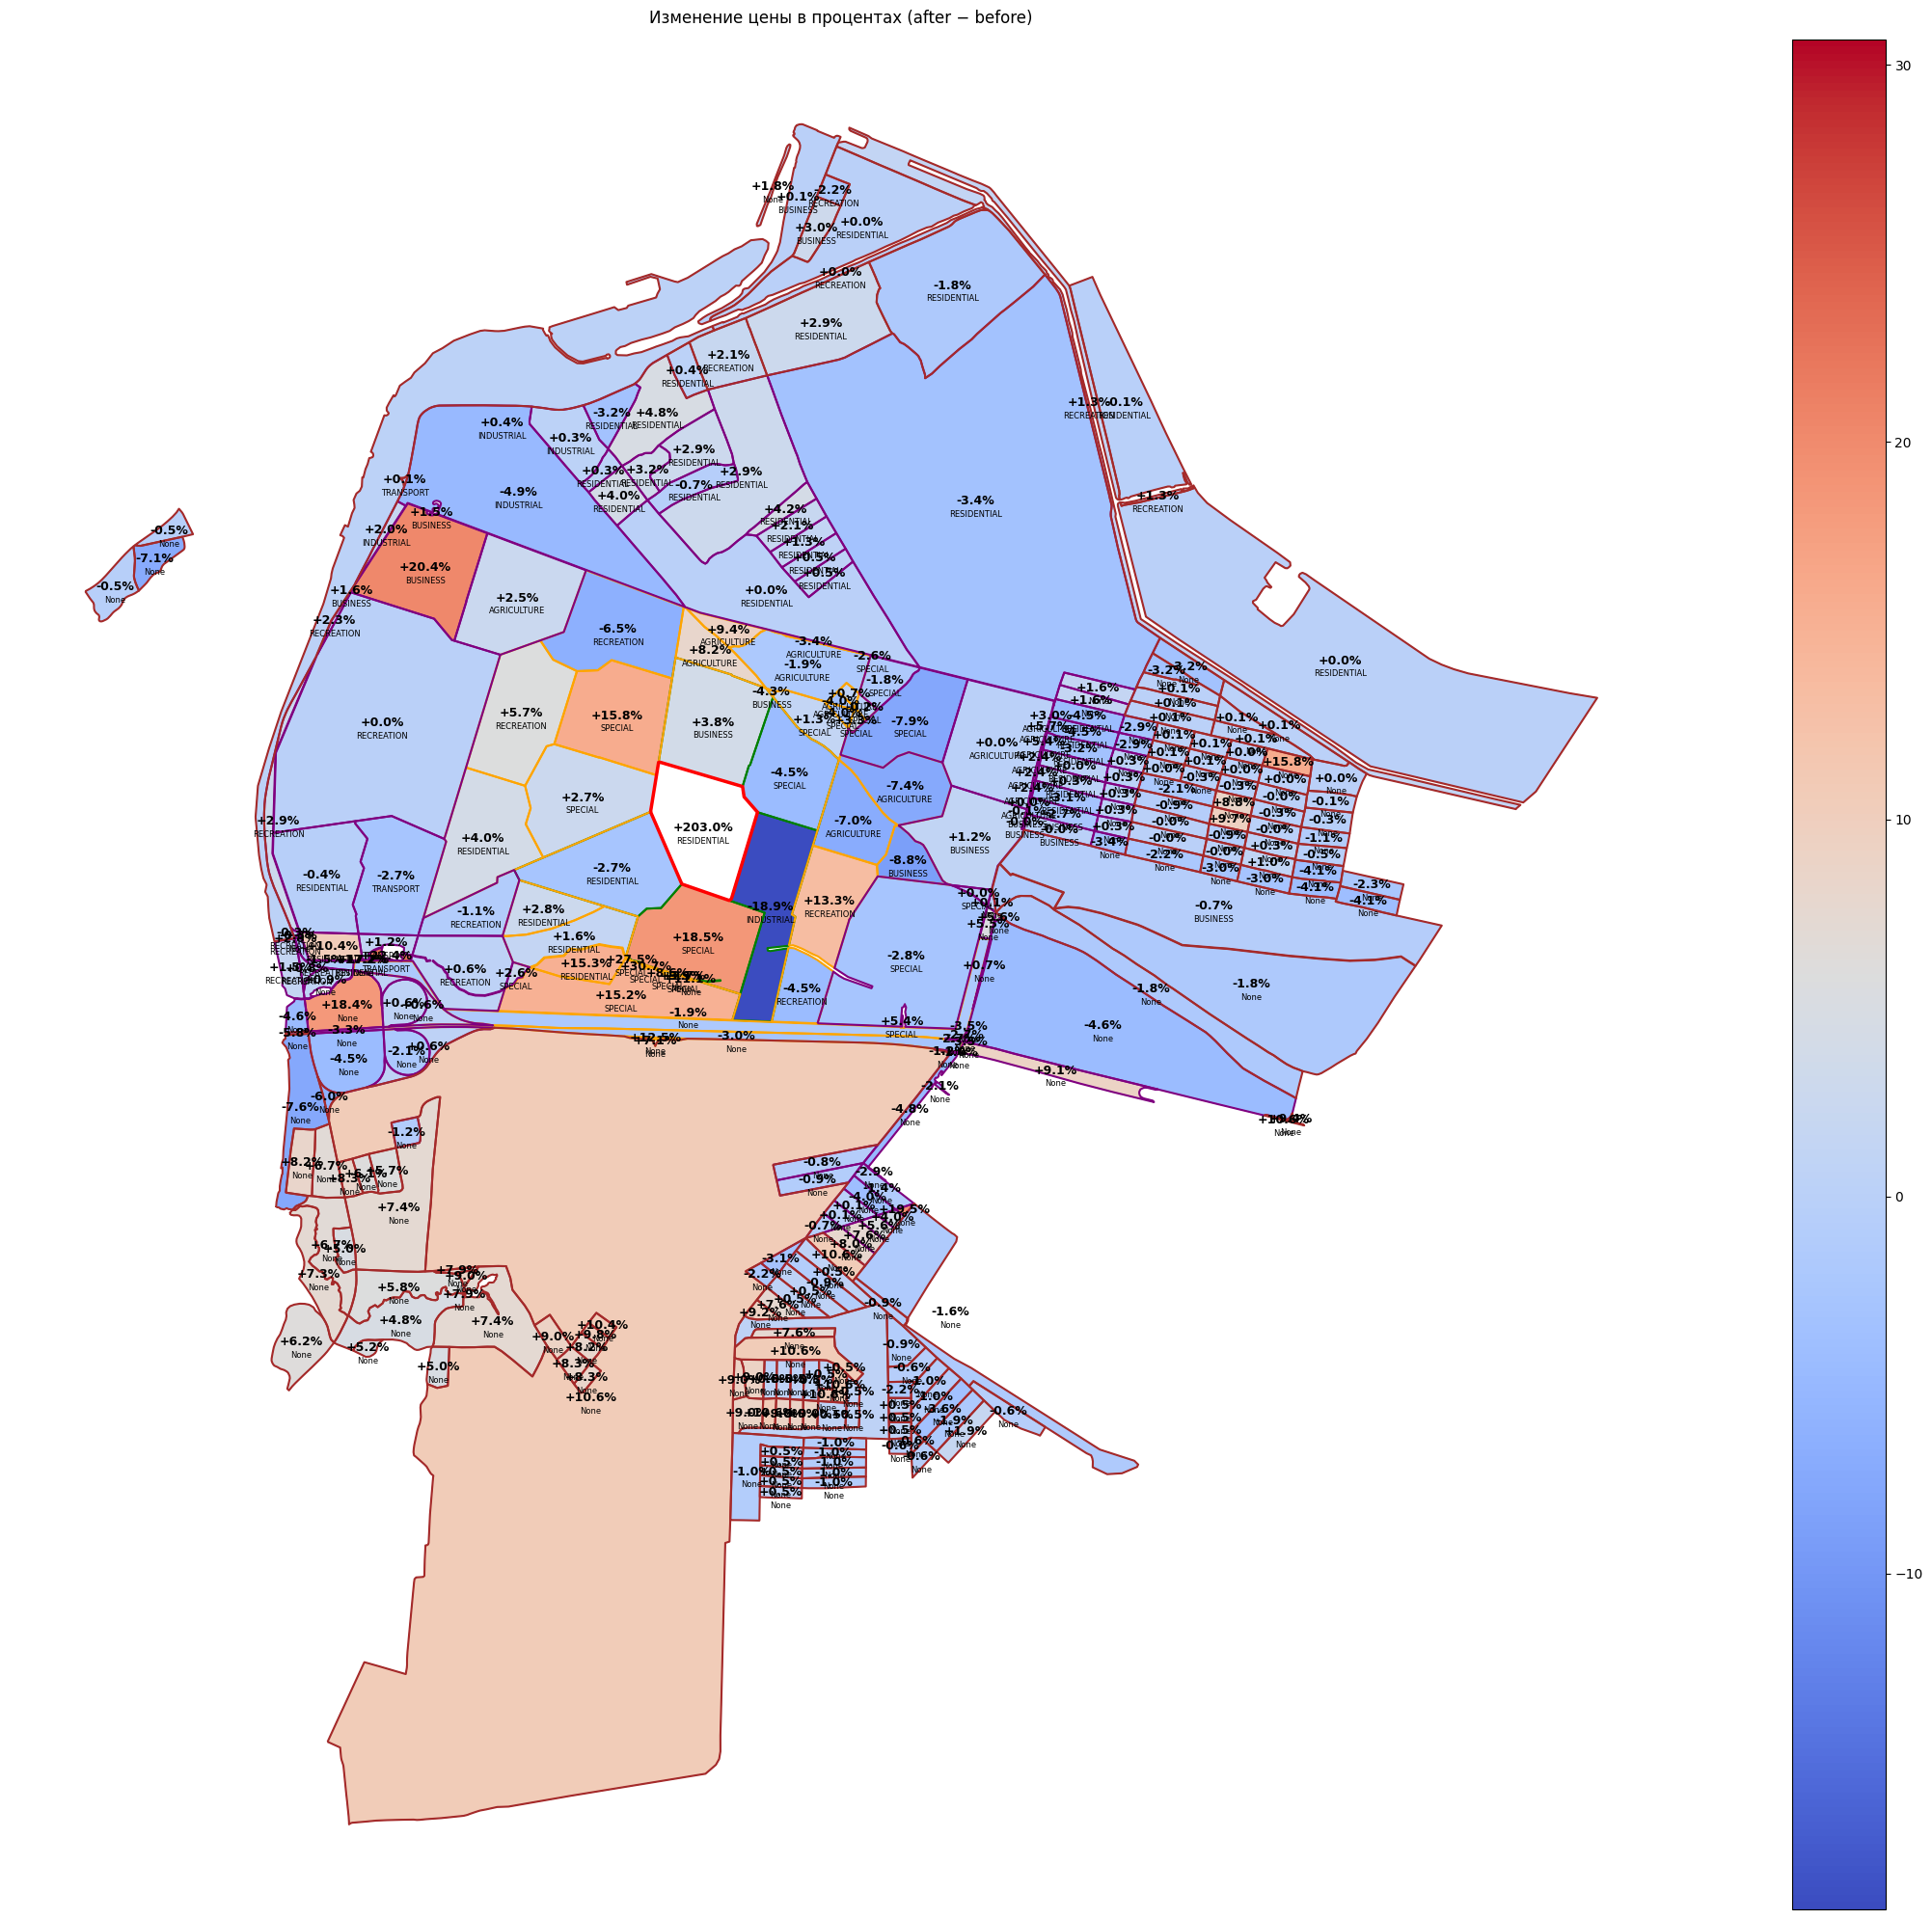

In [46]:
# ------------ 0. Библиотеки и константы ------------
import pandas as pd
import numpy as np
import geopandas as gpd
from catboost import CatBoostRegressor
from libpysal.weights import DistanceBand, lag_spatial
import matplotlib.pyplot as plt

# Список исходных фичей
orig_feats = [
    'residential','business','recreation','industrial','transport','special',
    'agriculture','land_use','share','footprint_area','build_floor_area',
    'living_area','non_living_area','population','site_area','fsi','gsi',
    'mxi','l','morphotype','area_accessibility'
]
# Категориальные фичи
cat_feats = ['land_use', 'morphotype']
numeric_feats = [c for c in orig_feats if c not in cat_feats]

# Радиусы для матриц соседства
radius_list = [300, 500, 1000, 2000, 3000]

# ------------ 1. Загрузка данных и модели ------------
# Предполагается, что у вас уже загружен GeoDataFrame blocks, например:
# blocks = gpd.read_file('blocks.geojson')

model = CatBoostRegressor()
model.load_model('/home/mvin/prostor-examples/examples/data/catboost_model.cbm')

# ------------ 2. Построение матриц соседства ------------
w_radii = {}
for r in radius_list:
    w = DistanceBand.from_dataframe(
        blocks, threshold=r, binary=True, silence_warnings=True
    )
    w.transform = 'r'
    w_radii[r] = w

# ------------ 3. Функция визуализации ------------
def plot_scenario_with_radii(
    blocks, w_radii, model,
    orig_feats, numeric_feats,
    target_idx, changes
):
    radius_list = sorted(w_radii.keys())

    # 0) сбор соседей
    radius_ids = {}
    prev = set()
    for r in radius_list:
        ids = set(w_radii[r].neighbors.get(target_idx, [])) - prev
        radius_ids[r] = sorted(ids)
        prev |= ids
    idxs         = [target_idx] + [i for r in radius_list for i in radius_ids[r]]
    neighbor_idxs = [i for i in idxs if i != target_idx]

    # 1) лаги до
    blocks_base = blocks.copy()
    lag_cols, gm = [], blocks_base[numeric_feats].mean()
    for feat in numeric_feats:
        vec = blocks_base[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_base[col] = lag_spatial(w_radii[r], vec)
            lag_cols.append(col)
    for r in radius_list:
        ncol = f'n_neighbors_{r}'
        blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
        lag_cols.append(ncol)
    all_feats = orig_feats + lag_cols

    Xb = blocks_base.loc[idxs, all_feats].copy()
    Xb['land_use']   = Xb['land_use'].fillna('missing').astype('category')
    Xb['morphotype'] = Xb['morphotype'].fillna('missing').astype('category')
    preds_before     = model.predict(Xb)

    # 2) изменения + лаги после
    blocks_scn = blocks_base.copy()
    for feat, val in changes.items():
        blocks_scn.at[target_idx, feat] = val
    for feat in numeric_feats:
        vec = blocks_scn[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_scn[col] = lag_spatial(w_radii[r], vec)

    Xa = blocks_scn.loc[idxs, all_feats].copy()
    Xa['land_use']   = Xa['land_use'].fillna('missing').astype('category')
    Xa['morphotype'] = Xa['morphotype'].fillna('missing').astype('category')
    preds_after      = model.predict(Xa)

    # 3) собираем gdf
    gdf = blocks_scn.loc[idxs].copy()
    gdf['pred_before'] = preds_before
    gdf['pred_after']  = preds_after
    gdf['log_diff']    = gdf['pred_after'] - gdf['pred_before']
    gdf['pct_change']  = (np.exp(gdf['log_diff']) - 1) * 100

    # 4) Текстовый отчёт (восстановленный)
    def ntype(i):
        if i == target_idx: return 'target'
        for r in radius_list:
            if i in radius_ids[r]: return f'radius_{r}m'
        return 'other'

    print("Δ цены в процентах (после − до):")
    for i, row in gdf.iterrows():
        b = row['pred_before']
        a = row['pred_after']
        d = row['log_diff']
        p = row['pct_change']
        print(
            f" • {i} ({ntype(i)}): "
            f"{b:.3f} → {a:.3f} "
            f"(Δ {d:+.3f} log, {p:+.1f}%)"
        )

        # 6) Сводная статистика по радиусам
    stats = []
    for r in radius_list:
        ids = radius_ids[r]
        if ids:
            mean_pct = gdf.loc[ids, 'pct_change'].mean()
            std_pct = gdf.loc[ids, 'pct_change'].std()
            stats.append((r, mean_pct, std_pct, len(ids)))
        else:
            stats.append((r, np.nan, np.nan, 0))

    print("\nСреднее изменение цены по радиусам:")
    for r, m, s, n in stats:
        print(f" • Радиус {r}м: среднее {m:+.1f}%, std {s:.1f}, участков {n}")

    # ————— добавляем вывод итогового среднего —————
    # собираем всех соседей во всех радиусах
    all_neighbor_ids = [i for r in radius_list for i in radius_ids[r]]
    if all_neighbor_ids:
        overall_mean = gdf.loc[all_neighbor_ids, 'pct_change'].mean()
        overall_std = gdf.loc[all_neighbor_ids, 'pct_change'].std()
        total_n = len(all_neighbor_ids)
        print(f"\nИтоговое среднее изменение цены по всем соседям: "
              f"{overall_mean:+.1f}% (std {overall_std:.1f}%, участков {total_n})")
    else:
        print("\nНет соседей для расчёта итогового среднего.")

    # 5) Визуализация
    fig, ax = plt.subplots(figsize=(25, 20))

    # 5.1 цвет только соседей
    vmin = gdf.loc[neighbor_idxs, 'pct_change'].min()
    vmax = gdf.loc[neighbor_idxs, 'pct_change'].max()
    gdf.loc[neighbor_idxs].plot(
        ax=ax, column='pct_change', cmap='coolwarm',
        vmin=vmin, vmax=vmax, legend=True,
        edgecolor='black', linewidth=0.5, zorder=1
    )

    # 5.2 обводки и подписи
    from matplotlib.lines import Line2D
    from matplotlib.transforms import offset_copy

    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    for color, r in zip(colors, radius_list):
        ids = radius_ids[r]
        if ids:
            gdf.loc[ids].boundary.plot(ax=ax, color=color, linewidth=1.5, zorder=2)

    gdf.loc[[target_idx]].boundary.plot(
        ax=ax, edgecolor='red', linewidth=2.5, zorder=3
    )

    for i, row in gdf.iterrows():
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, f"{row['pct_change']:+.1f}%", ha='center', va='center',
                fontsize=9, fontweight='bold', zorder=4)
        ax.text(x, y, str(row['land_use']),
                ha='center', va='center', fontsize=6, zorder=4,
                transform=offset_copy(ax.transData, fig=fig, y=-10, units='points'))

    ax.axis('off')
    ax.set_title('Изменение цены в процентах (after − before)', pad=12)
    plt.tight_layout()
    plt.show()



# ------------ 5. Пример использования ------------
target_idx = 15
changes = {
    'land_use': 'RESIDENTIAL',
    'share': 0.95,
    'footprint_area': 49039.24,
    'build_floor_area': 230279.19,
    'living_area': 155896.85,
    'population': 5168,
    'fsi': 2.80,
    'mxi': 0.68,
    'l': 6.93,
    'share_living': 4.69
}

plot_scenario_with_radii(
    blocks=blocks,
    w_radii=w_radii,
    model=model,
    orig_feats=orig_feats,
    numeric_feats=numeric_feats,
    target_idx=target_idx,
    changes=changes
)


In [51]:
import numpy as np
import pandas as pd
import geopandas as gpd
from libpysal.weights import lag_spatial

# Предполагаем, что у вас уже есть:
# blocks, model, orig_feats, numeric_feats, radius_list, w_radii, target_idx, changes

# ——— 1) Построим лаг-признаки так же, как в функции ———
blocks_base = blocks.copy()
lag_cols = []
gm = blocks_base[numeric_feats].mean()

for feat in numeric_feats:
    vec = blocks_base[feat].fillna(gm[feat])
    for r in radius_list:
        col = f'lag{r}_{feat}'
        blocks_base[col] = lag_spatial(w_radii[r], vec)
        lag_cols.append(col)
for r in radius_list:
    ncol = f'n_neighbors_{r}'
    blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
    lag_cols.append(ncol)

all_feats = orig_feats + lag_cols

# ——— 2) Определим idxs, как в вашей функции ———
radius_ids = {}
prev = set()
for r in radius_list:
    ids = set(w_radii[r].neighbors.get(target_idx, [])) - prev
    radius_ids[r] = sorted(ids)
    prev |= ids

idxs = [target_idx] + [i for r in radius_list for i in radius_ids[r]]

# ——— 3) Предсказания до изменений ———
Xb = blocks_base.loc[idxs, all_feats].copy()
Xb['land_use']   = Xb['land_use'].fillna('missing').astype('category')
Xb['morphotype'] = Xb['morphotype'].fillna('missing').astype('category')
preds_before    = model.predict(Xb)

# ——— 4) Вносим изменения и пересчитываем лаги ———
blocks_scn = blocks_base.copy()
for feat, val in changes.items():
    blocks_scn.at[target_idx, feat] = val

for feat in numeric_feats:
    vec = blocks_scn[feat].fillna(gm[feat])
    for r in radius_list:
        col = f'lag{r}_{feat}'
        blocks_scn[col] = lag_spatial(w_radii[r], vec)

Xa = blocks_scn.loc[idxs, all_feats].copy()
Xa['land_use']   = Xa['land_use'].fillna('missing').astype('category')
Xa['morphotype'] = Xa['morphotype'].fillna('missing').astype('category')
preds_after     = model.predict(Xa)

# ——— 5) Собираем единый GeoDataFrame ———
gdf = blocks_scn.loc[idxs].copy()
gdf['pred_log_before'] = preds_before
gdf['pred_price_before'] = np.exp(preds_before)
gdf['pred_log_after']  = preds_after
gdf['pred_price_after'] = np.exp(preds_after)

# (по желанию можно добавить log_diff и pct_change)
gdf['log_diff']   = gdf['pred_log_after'] - gdf['pred_log_before']
gdf['pct_change'] = (np.exp(gdf['log_diff']) - 1) * 100

# ——— 6) Сохраняем в один GeoJSON ———
gdf.to_file('predictions_before_after.geojson', driver='GeoJSON')


/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

In [52]:
gdf

,residential,business,recreation,industrial,transport,special,agriculture,land_use,share,footprint_area,...,n_neighbors_1000,n_neighbors_2000,n_neighbors_3000,share_living,pred_log_before,pred_price_before,pred_log_after,pred_price_after,log_diff,pct_change
15,0.0,0.00000,0.937538,0.000000,0.0,0.000000,0.0,RESIDENTIAL,0.950000,49039.240000,...,40,154,306,4.69,18.051505,6.913041e+07,19.160149,2.094821e+08,1.108644,203.024599
10,0.0,0.00000,0.000000,0.000000,0.0,0.939528,0.0,SPECIAL,0.939528,9166.404206,...,28,163,322,NaN,18.047313,6.884120e+07,18.217395,8.160451e+07,0.170082,18.540215
11,0.0,0.00000,0.000000,0.904851,0.0,0.000000,0.0,INDUSTRIAL,0.904851,48466.581276,...,37,153,336,NaN,19.040262,1.858150e+08,18.830695,1.506839e+08,-0.209567,-18.906483
17,0.0,0.00000,0.000000,0.000000,0.0,0.951242,0.0,SPECIAL,0.951242,18882.260526,...,34,149,311,NaN,18.109277,7.324178e+07,18.063165,6.994114e+07,-0.046112,-4.506506
32,0.0,0.94631,0.000000,0.000000,0.0,0.000000,0.0,BUSINESS,0.946310,34580.059668,...,31,130,275,NaN,18.676668,1.291736e+08,18.713680,1.340441e+08,0.037012,3.770523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,None,NaN,1187.014373,...,86,160,243,NaN,15.236700,4.142044e+06,15.320715,4.505074e+06,0.084015,8.764520
2414,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,None,NaN,1268.584580,...,86,159,240,NaN,15.713567,6.672914e+06,15.710564,6.652902e+06,-0.003003,-0.299886
2417,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,None,NaN,1184.299187,...,84,159,236,NaN,15.623272,6.096785e+06,15.623272,6.096785e+06,0.000000,0.000000
2420,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,None,NaN,2158.941465,...,72,151,222,NaN,16.535697,1.518316e+07,16.494211,1.456615e+07,-0.041487,-4.063785
